In [41]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [42]:
data=pd.read_csv('Final_Model_Data.csv')
print(data)

       DrugUse  MentalIllness  Age  EmploymentStatus  Sex  IncomeLevel  \
0            1              0    1                 1    1            1   
1            1              0    1                 1    1            1   
2            0              0    1                 1    0            1   
3            0              0    1                 1    1            1   
4            0              0    1                 0    0            1   
...        ...            ...  ...               ...  ...          ...   
25687        1              0    0                 0    0            1   
25688        0              1    1                 0    1            1   
25689        0              1    1                 1    1            1   
25690        1              1    1                 1    0            1   
25691        1              1    1                 0    0            1   

       UrbanRural  EducationLevel  
0               0               1  
1               1               1  
2  

In [43]:
data.head()

,DrugUse,MentalIllness,Age,EmploymentStatus,Sex,IncomeLevel,UrbanRural,EducationLevel
0,1,0,1,1,1,1,0,1
1,1,0,1,1,1,1,1,1
2,0,0,1,1,0,1,1,1
3,0,0,1,1,1,1,1,1
4,0,0,1,0,0,1,1,1


In [44]:
causal_graph = """strict digraph  {
DrugUse;
MentalIllness;
Age;
EmploymentStatus;
Sex;
IncomeLevel;
UrbanRural;
EducationLevel;
Age -> MentalIllness;
Age -> EmploymentStatus;
Age -> IncomeLevel;
Age -> EducationLevel;
Sex -> EmploymentStatus;
Sex -> MentalIllness;
Sex -> DrugUse;
Sex -> EducationLevel;
Sex -> IncomeLevel;
MentalIllness -> EmploymentStatus;
MentalIllness -> EducationLevel;
MentalIllness -> IncomeLevel;
MentalIllness -> DrugUse;
UrbanRural -> DrugUse;
UrbanRural -> IncomeLevel;
UrbanRural -> EducationLevel;
DrugUse -> IncomeLevel;
IncomeLevel -> EducationLevel;
EmploymentStatus -> IncomeLevel;
EmploymentStatus -> EducationLevel;
}

"""

In [45]:
model=CausalModel(
        data = data,
        graph=causal_graph,
        treatment="MentalIllness",
        outcome="DrugUse")

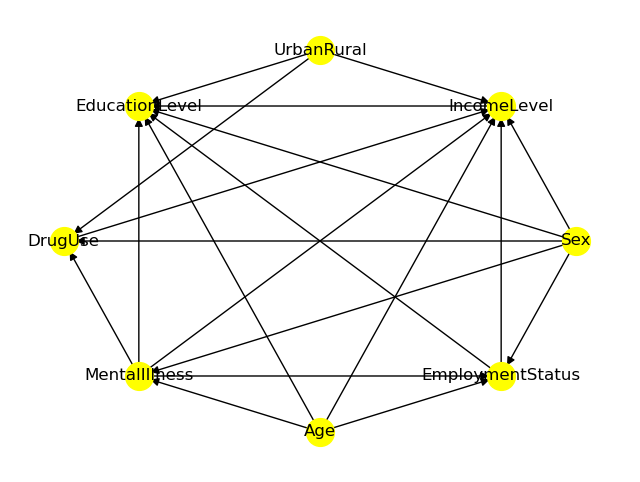

In [46]:
model.view_model()

In [47]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                        
────────────────(E[DrugUse|Sex])
d[MentalIllness]                
Estimand assumption 1, Unconfoundedness: If U→{MentalIllness} and U→DrugUse then P(DrugUse|MentalIllness,Sex,U) = P(DrugUse|MentalIllness,Sex)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                         -1⎤
 ⎢  d             ⎛  d                    ⎞  ⎥
E⎢──────(DrugUse)⋅⎜──────([MentalIllness])⎟  ⎥
 ⎣d[Age]          ⎝d[Age]                 ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→DrugUse then ¬(U →→{Age})
Estimand assumption 2, Exclusion: If we remove {Age}→{MentalIllness}, then ¬({Age}→DrugUse)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [48]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                        
────────────────(E[DrugUse|Sex])
d[MentalIllness]                
Estimand assumption 1, Unconfoundedness: If U→{MentalIllness} and U→DrugUse then P(DrugUse|MentalIllness,Sex,U) = P(DrugUse|MentalIllness,Sex)

## Realized estimand
b: DrugUse~MentalIllness+Sex+MentalIllness*UrbanRural
Target units: ate

## Estimate
Mean value: 0.21054064455347252
p-value: [6.38714095e-131]
### Conditional Estimates
__categorical__UrbanRural
(-0.001, 1.0]    0.210541
dtype: float64
Causal Estimate is 0.21054064455347252


In [49]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Age'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))



instrumental_variable
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                         -1⎤
 ⎢  d             ⎛  d                    ⎞  ⎥
E⎢──────(DrugUse)⋅⎜──────([MentalIllness])⎟  ⎥
 ⎣d[Age]          ⎝d[Age]                 ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→DrugUse then ¬(U →→{Age})
Estimand assumption 2, Exclusion: If we remove {Age}→{MentalIllness}, then ¬({Age}→DrugUse)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡ d           ⎤  -1⎡ d                 ⎤
E⎢────(DrugUse)⎥⋅E  ⎢────(MentalIllness)⎥
 ⎣dAge         ⎦    ⎣dAge               ⎦
Estimand assumption 1, As-if-random: If U→→DrugUse then ¬(U →→{Age})
Estimand assumption 2, Exclusion: If we remove {Age}→{MentalIllness}, then ¬({Age}→DrugUse)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['MentalIl

In [73]:
refutation = model.refute_estimate(identified_estimand, 
                                    causal_estimate_reg,
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", num_simulations=20)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0,

In [74]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.21054064455347252
New effect:0.0005442357979766957
p value:0.45339891686912076



In [71]:
refutation_iv = model.refute_estimate(identified_estimand, 
                                    causal_estimate_iv,
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", num_simulations=20)

In [72]:
print(refutation_iv)

Refute: Use a Placebo Treatment
Estimated effect:0.2251115976010302
New effect:5.357683657792242
p value:0.3645644219745262



In [56]:
es_random = model.refute_estimate(identified_estimand,causal_estimate_reg, method_name="random_common_cause", show_progress_bar=True)


{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0,

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['UrbanRural']}
{'control_value': 0,

In [57]:
print(es_random)

Refute: Add a random common cause
Estimated effect:0.21054064455347252
New effect:0.21054037506693907
p value:0.96

